#Installing and Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [134]:
%pip install pylatexenc --quiet

In [135]:
%pip install qiskit --quiet
%pip install qiskit-aer --quiet

In [136]:
%pip install qiskit-machine-learning --quiet

In [137]:
%pip install qiskit-algorithms --quiet

In [139]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow import keras

import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, TwoLocal
import pylatexenc

from qiskit_aer.noise import (
    NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error,
    phase_damping_error, amplitude_damping_error
)

#Noise Models

In [140]:
def noise_bit_flip_error(p):
    error_gate = pauli_error([('X', p), ('I', 1 - p)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate, ["u1", "u2", "u3"])
    return noise_model
def noise_measure_error(p):
    error_meas = pauli_error([('X', p), ('I', 1 - p)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    return noise_model
def noise_phase_flip_error(p):
    error_phase_flip = pauli_error([('Z', p), ('I', 1 - p)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_phase_flip, ["u1", "u2", "u3"])
    return noise_model

def noise_cx_error(p):
    error_gate = pauli_error([('X', p), ('I', 1 - p)])
    error_cx = error_gate.tensor(error_gate)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_cx, "cx")
    return noise_model

def noise_phase_damping_error(p):
    error_gate=phase_damping_error(p)
    noise_model=NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate,["u1", "u2", "u3"])
    return noise_model

def noise_amplitude_damping_error(p):
    error_gate=amplitude_damping_error(p)
    noise_model=NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate,["u1", "u2", "u3"])
    return noise_model


def noise_depolarizing_error(p):
    error_gate=depolarizing_error(p,4)
    noise_model=NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate,"dp")
    return noise_model

#UUDagger Circuit

In [9]:
def U_circuit(qc,theta):
  qc.u(theta[0],0,0,0)
  qc.cu(theta[1],0,0,0,0,1)
  qc.x(0)
  qc.cu(theta[2],0,0,0,0,1)
  qc.x(0)

  qc.mcx([0, 1], 3)
  qc.cu(theta[3],0,0,0,3,2)
  qc.mcx([0, 1], 3)

  qc.x(0)
  qc.mcx([0, 1], 3)
  qc.cu(theta[4],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(0)

  qc.x(1)
  qc.mcx([0, 1], 3)
  qc.cu(theta[5],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(1)

  qc.x(0)
  qc.x(1)
  qc.mcx([0, 1], 3)
  qc.cu(theta[6],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(0)
  qc.x(1)
  return qc

def U_circuit_rev(qc,theta):
  qc.x(0)
  qc.x(1)
  qc.mcx([0, 1], 3)
  qc.cu(-theta[6],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(0)
  qc.x(1)

  qc.x(1)
  qc.mcx([0, 1], 3)
  qc.cu(-theta[5],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(1)

  qc.x(0)
  qc.mcx([0, 1], 3)
  qc.cu(-theta[4],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(0)

  qc.mcx([0, 1], 3)
  qc.cu(-theta[3],0,0,0,3,2)
  qc.mcx([0, 1], 3)

  qc.x(0)
  qc.cu(-theta[2],0,0,0,0,1)
  qc.x(0)

  qc.cu(-theta[1],0,0,0,0,1)

  qc.u(-theta[0],0,0,0)

  return qc

# Datasets

## MedQUAD (HCD)

In [141]:
max_length=51
import pandas as pd
df = pd.read_csv(r'/content/drive/MyDrive/LLM Healthcare/medquad.csv', usecols=['question', 'focus_area'])
arr=df.to_numpy()
# Label count and index
label_count={}
for i in arr:
  label_count[i[-1]]=label_count.get(i[-1],0)+1
labels_count=sorted(label_count.items(),key=lambda x:-x[1])
label_index={i[0]:j for j,i in enumerate(labels_count)}
#Word count and index
word_counts={}
for i in arr:
  for j in i[0].split():
    word_counts[j]=word_counts.get(j,0)+1
word_counts=sorted(word_counts.items(),key=lambda x:-x[1])
word_index={i[0]:j+1 for j,i in enumerate(word_counts)}
word_index['PAD']=0
word_index=dict(sorted(word_index.items(),key=lambda x:x[1]))
#Tokenization
def tokenization(words):
  token=[]
  for i in words:
    k=[]
    for j in i.split():
      k.append(word_index[j])
    token.append(k)
  return token
# Tokenizing the data
tokenized_data=tokenization([i[0] for i in arr])
labels=[label_index[i[1]] for i in arr]
#Padding the data
data= keras.preprocessing.sequence.pad_sequences(tokenized_data,maxlen=max_length,padding="post")
#Only selecting two labels
new_data,label=[],[]
for i,j in zip(data,labels):
  if j<2:
    new_data.append(i)
    label.append(j)
combined_data=pd.DataFrame(np.c_[new_data,label])
h_data=new_data
h_label= label
combined_data.columns = list(combined_data.columns)[:-1] + ['Cluster']

In [101]:
df = combined_data
cluster = np.array(df['Cluster'])

In [102]:
numeric_cols = df.select_dtypes(include=np.number).columns

all_zero_cols = [col for col in numeric_cols if df[col].sum() == 0]

df_cleaned = df.drop(columns=all_zero_cols)

In [103]:
df = df_cleaned

In [104]:
# Convert each row to a NumPy array
row_arrays = []
for index, row in df.iterrows():
    row_arrays.append(row.to_numpy())

In [105]:
h_data = row_arrays

In [107]:
N=4
num_data_points=50
test_size=0.2

zeros_string = '0' * N
Num_shots=1024

df_sampled = df.sample(n=num_data_points, replace=True, random_state=42)


X = df_sampled.drop('Cluster', axis=1)  # Assuming 'Cluster' is the target variable
y = df_sampled['Cluster']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

n_components = min(X_scaled.shape[0], X_scaled.shape[1])
pca = PCA(n_components=n_components)

pca = PCA().fit(X_scaled)

X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

num_clusters=2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(df_pca)

centroids = kmeans.cluster_centers_

# Print centroid 0 and centroid 1
centroid_0 = centroids[0]
centroid_1 = centroids[1]

# Add the cluster labels to the DataFramez
df_pca['Cluster'] = labels

A = df_pca.drop('Cluster', axis=1)  # Assuming 'Cluster' is the target variable
B = df_pca['Cluster']

In [110]:
# Generate a range of noise levels
p_values = np.linspace(0, 1, 22)

# Initialize a dictionary to store results
results = {
    "bit_flip_error": [],
    "measure_error": [],
    "phase_flip_error": [],
    "depolarizing_error": [],
    "phase_damping_error":[],
    "amplitude_damping_error":[]
}

# Collect results for gate errors

# Split data into training and test sets for evaluating noise models
X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=test_size, random_state=42, stratify=B)

# Recalculate centroids based on the training data
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X_train)
fold_centroids = kmeans.cluster_centers_

def func(X_test, y_test, fold_centroids, N, noise_model):
    zeros_string = '0' * N
    predicted_labels = []

    for i in range(len(X_test)):
        x = X_test.iloc[i].values

        qc1 = QuantumCircuit(N+1, N)

        #change
        ansatz = TwoLocal(N+1, reps=4, entanglement='linear')
        param_values = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=ansatz.num_parameters)
        #print(param_values)
        ansatz.assign_parameters(param_values, inplace=True)
        qc1.compose(ansatz.decompose(), inplace=True)

        featuremap = ZZFeatureMap(N+1, reps=3, entanglement='linear')
        param_values = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=featuremap.num_parameters)
        #print(param_values)
        featuremap.assign_parameters(param_values, inplace=True)
        qc1.compose(featuremap.decompose(), inplace=True)

        qc1 = U_circuit(qc1, x)
        qc1 = U_circuit_rev(qc1, fold_centroids[0])
        qc1.measure(range(N), range(N))
        #Noise
        sim_noise = AerSimulator(noise_model=noise_model)
        circ_tnoise = transpile(qc1, sim_noise)
        result1 = sim_noise.run(circ_tnoise, shots=Num_shots).result()
        p0_qc1 = result1.get_counts(0).get(zeros_string, 0) / Num_shots
        #2nd Part

        #qc2
        qc2 = QuantumCircuit(N+1, N)
        qc2 = U_circuit(qc2, x)
        qc2 = U_circuit_rev(qc2, fold_centroids[1])
        qc2.measure(range(N), range(N))
        #Noise
        # Transpile circuit for noisy basis gates
        circ_tnoise = transpile(qc2, sim_noise)
        # Run and get counts
        result2 = sim_noise.run(circ_tnoise, shots=Num_shots).result()
        p0_qc2 = result2.get_counts(0).get(zeros_string, 0) / Num_shots
        predicted_labels.append(0 if p0_qc1 > p0_qc2 else 1)

      # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, predicted_labels)
    precision = precision_score(y_test, predicted_labels)
    recall = recall_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels)

    return accuracy

for p in tqdm(p_values):
    noise_model = noise_bit_flip_error(p)
    results["bit_flip_error"].append(func(X_test, y_test, fold_centroids, N, noise_model))

    noise_model = noise_measure_error(p)
    results["measure_error"].append(func(X_test, y_test, fold_centroids, N, noise_model))

    noise_model = noise_phase_flip_error(p)
    results["phase_flip_error"].append(func(X_test, y_test, fold_centroids, N, noise_model))

    noise_model= noise_depolarizing_error(p)
    results["depolarizing_error"].append(func(X_test, y_test, fold_centroids, N, noise_model))

    noise_model= noise_phase_damping_error(p)
    results["phase_damping_error"].append(func(X_test, y_test, fold_centroids, N, noise_model))

    noise_model= noise_amplitude_damping_error(p)
    results["amplitude_damping_error"].append(func(X_test, y_test, fold_centroids, N, noise_model))

 59%|█████▉    | 13/22 [03:51<02:43, 18.18s/it]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 64%|██████▎   | 14/22 [04:10<02:28, 18.55s/it]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 68%|██████▊   | 15/22 [04:27<02:07, 18.17s/it]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

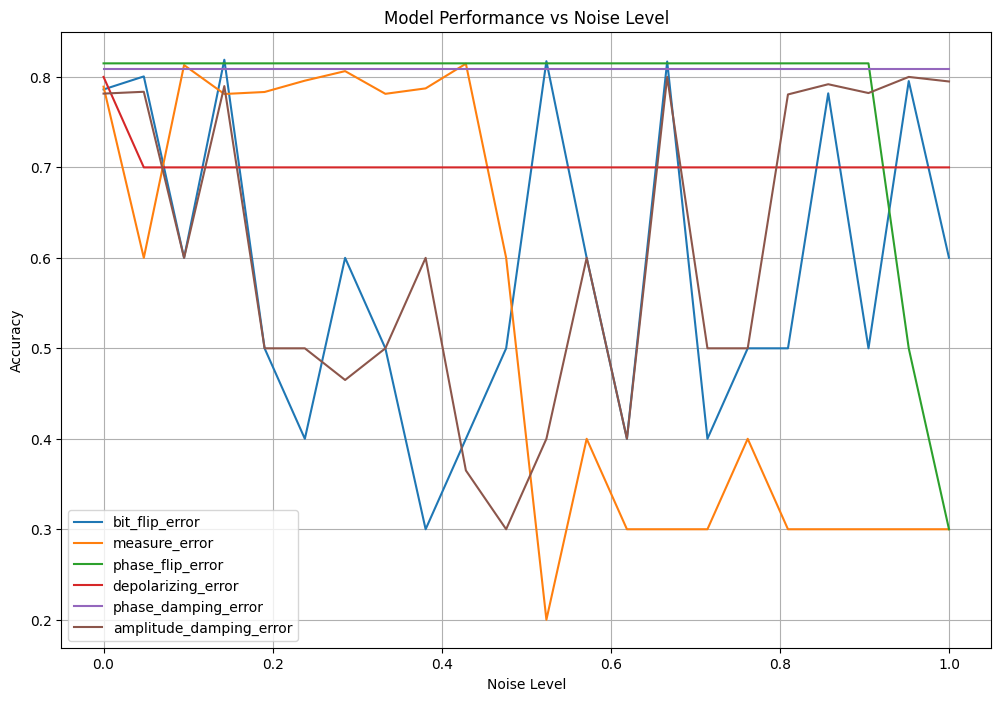

In [133]:
plt.figure(figsize=(12, 8))
for i in results.keys():
    plt.plot(p_values, results[i], label=i)
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.title('Model Performance vs Noise Level')
plt.legend()
plt.grid(True)
plt.show()

##  Medical Transcription Dataset

In [62]:
df = pd.read_csv(r'/content/drive/MyDrive/LLM Healthcare/mtsamples.csv', header=None)  # Add `names=` if needed
text_col = df.iloc[:, 4]
yes_texts = []
no_texts = []

for text in text_col.dropna():
    if 'diabetes' in text.lower():
        if len(yes_texts) < 100:
            yes_texts.append(text)
    else:
        if len(no_texts) < 100:
            no_texts.append(text)
    if len(yes_texts) >= 100 and len(no_texts) >= 100:
        break

texts = yes_texts + no_texts
labels = [1] * 100 + [0] * 100  # 1 for diabetes, 0 for not
# Step 3: Build vocabulary
word_counts = {}
for sentence in texts:
    for word in sentence.split():
        word_counts[word] = word_counts.get(word, 0) + 1

# Sort and index
word_counts = sorted(word_counts.items(), key=lambda x: -x[1])
word_index = {word: i+1 for i, (word, _) in enumerate(word_counts)}
word_index['PAD'] = 0
word_index = dict(sorted(word_index.items(), key=lambda x: x[1]))

# Step 4: Tokenization
def tokenize(sentences):
    tokenized = []
    for sentence in sentences:
        tokenized.append([word_index.get(word, 0) for word in sentence.split()])
    return tokenized

tokenized_data = tokenize(texts)

# Step 5: Padding
max_length = 51
padded_data = keras.preprocessing.sequence.pad_sequences(tokenized_data, maxlen=max_length, padding='post')

# Step 6: Final dataset
final_data = pd.DataFrame(np.c_[padded_data, labels])
m_data = padded_data
m_label = labels

In [65]:
N =4
num_data_points = 50
test_size = 0.2

zeros_string = '0' * N
Num_shots = 1024

num_components = 0
for i in range(N):
    num_components += 2 ** i

# Use final_data where last column is the label
df_sampled = final_data.sample(n=num_data_points, replace=True, random_state=42)

# Extract features and labels
X = df_sampled.iloc[:, :-1]  # All columns except the last one
y = df_sampled.iloc[:, -1]   # The last column as label

# MinMax transform
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# PCA transform
#pca = PCA(n_components=num_components)
n_components = min(X_scaled.shape[0], X_scaled.shape[1])
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

pca = PCA().fit(X_scaled)

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(df_pca)

centroids = kmeans.cluster_centers_

# Print centroid 0 and centroid 1
centroid_0 = centroids[0]
centroid_1 = centroids[1]

# Add the cluster labels to the DataFrame
df_pca['Cluster'] = labels

A = df_pca.drop('Cluster', axis=1)
B = df_pca['Cluster']

In [69]:
# Generate a range of noise levels
p_values = np.linspace(0, 1, 22)

# Initialize a dictionary to store results
results = {
    "bit_flip_error": [],
    "measure_error": [],
    "phase_flip_error": [],
    "depolarizing_error": [],
    "phase_damping_error":[],
    "amplitude_damping_error":[]
}

# Collect results for gate errors

# Split data into training and test sets for evaluating noise models
X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=test_size, random_state=42)

# Recalculate centroids based on the training data
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X_train)
fold_centroids = kmeans.cluster_centers_

def func(X_test, y_test, fold_centroids, N, noise_model):
    zeros_string = '0' * N
    predicted_labels = []

    for i in range(len(X_test)):
        x = X_test.iloc[i].values

        qc1 = QuantumCircuit(N+1, N)

        ansatz = TwoLocal(N+1, reps=4, entanglement='linear')
        param_values = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=ansatz.num_parameters)
        ansatz.assign_parameters(param_values, inplace=True)
        qc1.compose(ansatz.decompose(), inplace=True)

        featuremap = ZZFeatureMap(N+1, reps=3, entanglement='linear')
        param_values = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=featuremap.num_parameters)
        featuremap.assign_parameters(param_values, inplace=True)
        qc1.compose(featuremap.decompose(), inplace=True)

        qc1 = U_circuit(qc1, x)
        qc1 = U_circuit_rev(qc1, fold_centroids[0])
        qc1.measure(range(N), range(N))
        sim_noise = AerSimulator(noise_model=noise_model)
        circ_tnoise = transpile(qc1, sim_noise)
        result1 = sim_noise.run(circ_tnoise, shots=Num_shots).result()
        p0_qc1 = result1.get_counts(0).get(zeros_string, 0) / Num_shots

        qc2 = QuantumCircuit(N+1, N)
        qc2 = U_circuit(qc2, x)
        qc2 = U_circuit_rev(qc2, fold_centroids[1])
        qc2.measure(range(N), range(N))
        #Noise
        # Transpile circuit for noisy basis gates
        circ_tnoise = transpile(qc2, sim_noise)
        # Run and get counts
        result2 = sim_noise.run(circ_tnoise, shots=Num_shots).result()
        p0_qc2 = result2.get_counts(0).get(zeros_string, 0) / Num_shots
        predicted_labels.append(0 if p0_qc1 > p0_qc2 else 1)

      # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, predicted_labels)
    precision = precision_score(y_test, predicted_labels)
    recall = recall_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels)

    return accuracy

for p in tqdm(p_values):
    noise_model = noise_bit_flip_error(p)
    results["bit_flip_error"].append(func(X_test, y_test, fold_centroids, N, noise_model))

    noise_model = noise_measure_error(p)
    results["measure_error"].append(func(X_test, y_test, fold_centroids, N, noise_model))

    noise_model = noise_phase_flip_error(p)
    results["phase_flip_error"].append(func(X_test, y_test, fold_centroids, N, noise_model))

    noise_model= noise_depolarizing_error(p)
    results["depolarizing_error"].append(func(X_test, y_test, fold_centroids, N, noise_model))

    noise_model= noise_phase_damping_error(p)
    results["phase_damping_error"].append(func(X_test, y_test, fold_centroids, N, noise_model))

    noise_model= noise_amplitude_damping_error(p)
    results["amplitude_damping_error"].append(func(X_test, y_test, fold_centroids, N, noise_model))

 55%|█████▍    | 12/22 [03:31<03:00, 18.06s/it]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 59%|█████▉    | 13/22 [03:50<02:45, 18.34s/it]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 64%|██████▎   | 14/22 [04:08<02:26, 18.32s/it]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

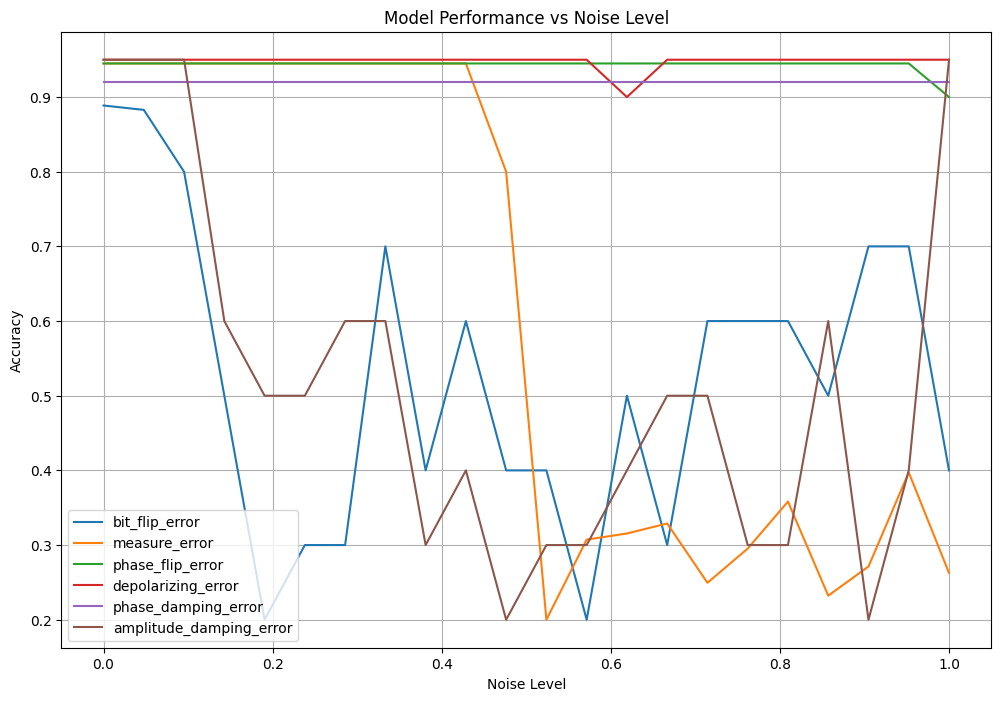

In [96]:
plt.figure(figsize=(12, 8))
for i in results.keys():
    plt.plot(p_values, results[i], label=i)
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.title('Model Performance vs Noise Level')
plt.legend()
plt.grid(True)
plt.show()